### インポート

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### アベレージヒッターのOPS

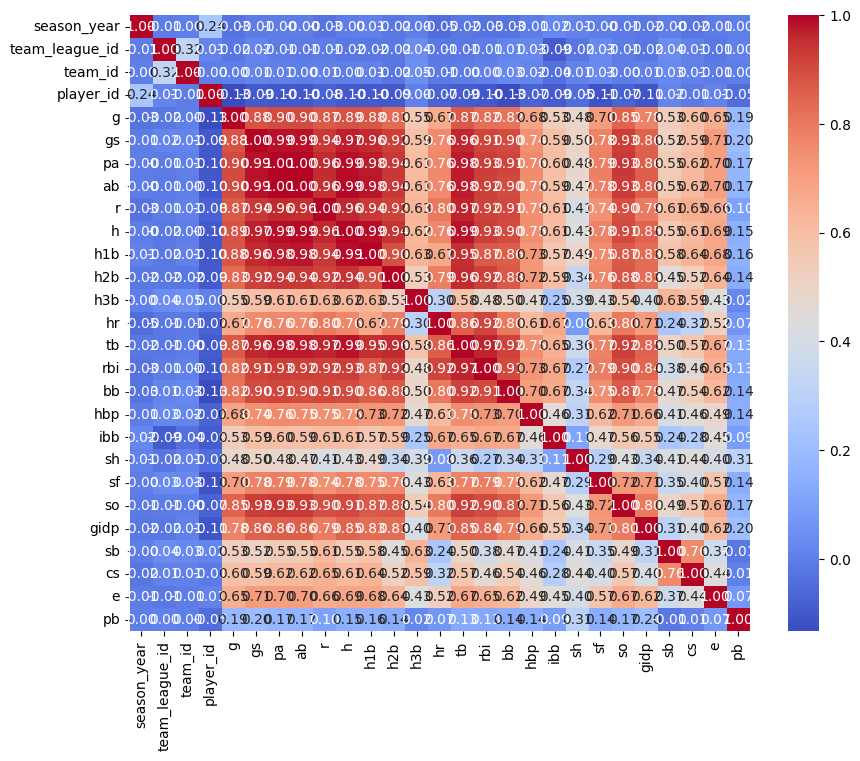

In [4]:
df = pd.read_csv("stats_bat.csv", encoding="cp932")

df_num = df.select_dtypes(include="number")

plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()